In [2]:
%pylab inline
# Import solar abundances
import os
FS=16
os.chdir('/home/oliverphilcox/ChempyMulti/')
tng=np.load("/mnt/store1/oliverphilcox/ChempyMultiData/TNG_galaxy_all.npz")

Populating the interactive namespace from numpy and matplotlib


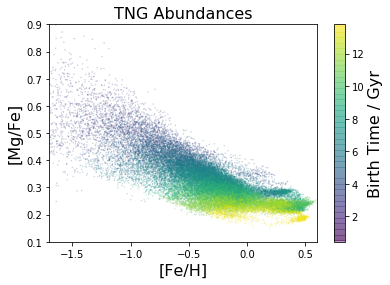

In [3]:
MgFeTNG=tng.f.abundance[:,3]
HeFeTNG=tng.f.abundance[:,2]
FeHTNG=tng.f.abundance[:,1]
timesTNG=tng.f.birth_time
plt.scatter(FeHTNG,MgFeTNG,alpha=0.4,s=0.1,c=timesTNG)
cb=plt.colorbar();
cb.set_label('Birth Time / Gyr',fontsize=FS)
plt.ylabel(r'[Mg/Fe]',fontsize=FS);plt.xlabel(r'[Fe/H]',fontsize=FS);
plt.title('TNG Abundances',fontsize=FS);
plt.xlim([-1.7,0.6]);plt.ylim([0.1,0.9]);

## Draw Chempy times from the SFR

In [8]:
from scipy.special import gamma
SFR_peak=10.**0.55
def SFR(t,k=2,theta=SFR_peak):
    return 1./(gamma(k)*theta**k)*t**(k-1)*np.exp(-t/theta)

In [28]:
t_grid = np.linspace(1.,13.8,100000)
sfr_grid = SFR(t_grid)/np.sum(SFR(t_grid))
t_samples = np.random.choice(t_grid,size=10000,p=sfr_grid)

(array([ 18.,  19.,  21.,  22.,  23.,  43.,  46.,  41.,  43.,  69.,  75.,
         75.,  98., 114.,  86., 116., 119., 172., 198., 242., 315., 501.,
        415., 370., 326., 300., 275., 338., 283., 277., 278., 268., 266.,
        292., 396., 522., 614., 588., 547., 425., 520., 537., 616., 523.,
        448., 458., 661., 754., 713., 792., 767., 773., 929., 782., 546.,
        582., 482., 507., 495., 547., 452., 405., 446., 446., 521., 469.,
        540., 474., 562., 577., 583., 580., 574., 489., 360., 379., 401.,
        459., 526., 550., 624., 615., 638., 594., 550., 522., 589., 618.,
        550., 491., 366., 371., 421., 369., 278., 224., 209., 260., 263.,
        263.]),
 array([ 0.44178323,  0.57531485,  0.70884647,  0.84237809,  0.97590971,
         1.10944133,  1.24297295,  1.37650456,  1.51003618,  1.6435678 ,
         1.77709942,  1.91063104,  2.04416266,  2.17769428,  2.3112259 ,
         2.44475751,  2.57828913,  2.71182075,  2.84535237,  2.97888399,
         3.11241561,  3.24

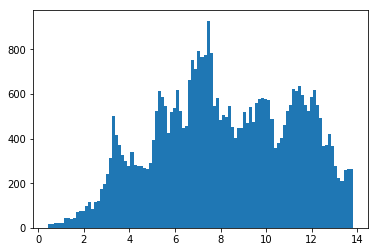

In [31]:
plt.hist(timesTNG,bins=100)

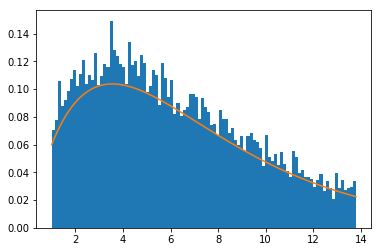

In [29]:
plt.hist(t_samples,density=True,bins=100)
plt.plot(t_grid,SFR(t_grid))

### Make some Chempy data:

In [52]:
from Chempy.parameter import ModelParameters
a=ModelParameters()
import multiprocessing as mp
import numpy as np
import tqdm, time
from scipy.stats import norm,uniform
from Chempy.cem_function import single_timestep_chempy

N_samples = 1000

sampled_tng_times = np.random.choice(timesTNG[timesTNG>1.],size=N_samples,replace=True)

widths = [0.,0.,0.,0.3,0.1,0.1]
priors = [-2.3,-2.89,0.,-0.3,0.55,0.5]
all_params=np.zeros([N_samples,len(priors)+1])
for i in range(len(all_params)):
    while all_params[i,4]<0.29402: # to avoid SFR errors
        all_params[i,:6]=norm.rvs(loc=priors,scale=widths)
    all_params[i,6]=sampled_tng_times[i]#uniform.rvs(loc=1.0,scale=12.8)
print("Created %d-element parameter set."%N_samples)

def runner(index):
    """Function to compute the Chempy predictions for each parameter set"""
    b=ModelParameters()
    params=all_params[index]
    output=single_timestep_chempy((params,b))
    if type(output)==float:
        if output==np.inf:
            del b
        outs=np.zeros(len(els)),params
    else: 
        abun=output[0]
        del b;
        outs=abun,params
    return outs

init_time=time.time()
    
# Compute elements by running code once:
output=single_timestep_chempy((list(priors)+[10.],a))
if output==np.inf:
    raise Exception("Bad SFR input even for prior parameters - check for bugs")
else:
    _,els=output

# Now run multiprocessing
cpus=mp.cpu_count()
p=mp.Pool(min(16,cpus))
output=list(tqdm.tqdm(p.imap_unordered(runner,range(N_samples)),total=N_samples))
abuns=[o[0] for o in output]
pars=[o[1] for o in output]

end_time=time.time()

print("multiprocessing complete after %d seconds"%(end_time-init_time));


Created 1000-element parameter set.


/home/oliverphilcox/ChempyMulti/Chempy/cem_function.py:126: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  time_model = float(basic_sfr.t[cut])
/home/oliverphilcox/ChempyMulti/Chempy/cem_function.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sfr_at_end = float(basic_sfr.sfr[cut] / basic_sfr.dt)
/home/oliverphilcox/ChempyMulti/Chempy/wrapper.py:236: RuntimeWarning: invalid value encountered in subtract
  abundances[element] -= abundances['Fe']

 95%|█████████▌| 951/1000 [00:49<00:02, 16.93it/s]


100%|██████████| 1000/1000 [00:52<00:00, 17.85it/s]


multiprocessing complete after 53 seconds


(array([0.00641488, 0.02407905, 0.06321912, 0.07801984, 0.11197222,
        0.11918664, 0.09096116, 0.09112851, 0.10767704, 0.05622783]),
 array([ 0.44178323,  1.77709942,  3.11241561,  4.44773179,  5.78304798,
         7.11836417,  8.45368036,  9.78899654, 11.12431273, 12.45962892,
        13.79494511]),
 <a list of 10 Patch objects>)

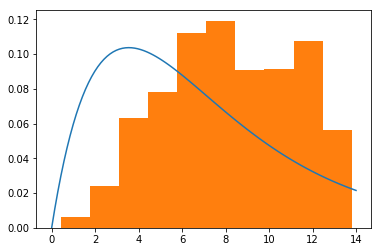

In [53]:
from scipy.special import gamma
def sfr(t,theta,k=2.):
    return t**(k-1.)/(gamma(k)*theta**k)*np.exp(-t/theta)
ts = np.linspace(0,14,100)
plt.plot(ts,sfr(ts,a.sfr_scale))
plt.hist(timesTNG,density=True)

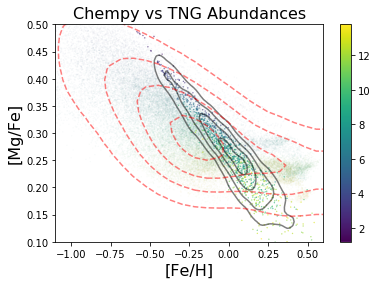

In [54]:
abuns = np.asarray(abuns)
pars = np.asarray(pars)
MgFeChempy=abuns[:,4]
HeFeChempy=abuns[:,3]#[:,4]
FeHChempy=abuns[:,1]
timesChempy=pars[:,-1]
plt.scatter(FeHTNG,MgFeTNG,alpha=0.04,s=0.1,c=timesTNG)
plt.scatter(FeHChempy,MgFeChempy,alpha=0.94,s=0.1,c=timesChempy)
from corner import hist2d as cohist
cohist(FeHChempy,MgFeChempy,bins=100,smooth=2.,no_fill_contours=True,plot_datapoints=False,
       contour_kwargs={'alpha':0.5},plot_density=False)
cohist(FeHTNG,MgFeTNG,bins=100,smooth=2.,no_fill_contours=True,plot_datapoints=False,
       contour_kwargs={'alpha':0.5,'linestyles':'--','colors':'r'},plot_density=False)
cb=plt.colorbar();
#cb.set_label('Birth Time / Gyr',fontsize=FS)
plt.ylabel(r'[Mg/Fe]',fontsize=FS);plt.xlabel(r'[Fe/H]',fontsize=FS);
plt.title('Chempy vs TNG Abundances',fontsize=FS);
plt.xlim([-1.1,0.6]);plt.ylim([0.1,0.5]);
#plt.xlim([-0.35,-0.21]);plt.ylim([0.2,0.4]);

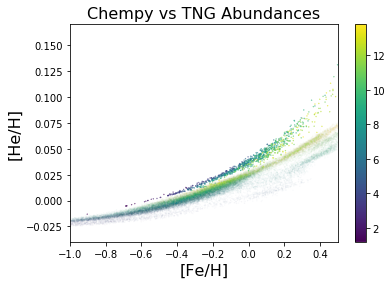

In [55]:
plt.scatter(FeHTNG,FeHTNG+HeFeTNG,alpha=0.04,s=0.1,c=timesTNG)
plt.scatter(FeHChempy,FeHChempy+HeFeChempy,alpha=0.94,s=0.1,c=timesChempy)
from corner import hist2d as cohist
#cohist(FeHChempy,MgFeChempy,bins=100,smooth=2.,no_fill_contours=True,plot_datapoints=False,
#       contour_kwargs={'alpha':0.5},plot_density=False)
#cohist(FeHTNG,MgFeTNG,bins=100,smooth=2.,no_fill_contours=True,plot_datapoints=False,
#       contour_kwargs={'alpha':0.5,'linestyles':'--','colors':'r'},plot_density=False)
cb=plt.colorbar();
#cb.set_label('Birth Time / Gyr',fontsize=FS)
plt.ylabel(r'[He/H]',fontsize=FS);plt.xlabel(r'[Fe/H]',fontsize=FS);
plt.title('Chempy vs TNG Abundances',fontsize=FS);
plt.xlim([-1,0.5]);
#plt.xlim([-1.1,0.6]);plt.ylim([0.1,0.5]);
#plt.xlim([-0.35,-0.21]);plt.ylim([0.2,0.4]);

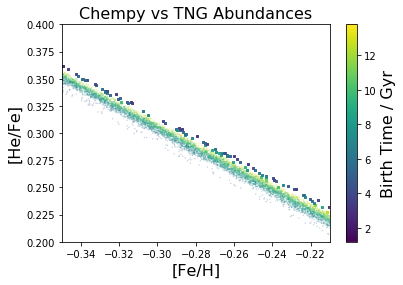

In [56]:
plt.scatter(FeHTNG,HeFeTNG,alpha=0.4,s=0.1,c=timesTNG)
plt.scatter(FeHChempy,HeFeChempy,alpha=0.94,s=4,marker='s',c=timesChempy)
from corner import hist2d as cohist
#cohist(FeHChempy,MgFeChempy,bins=100,smooth=2.,no_fill_contours=True,plot_datapoints=False,
#       contour_kwargs={'alpha':0.5},plot_density=False)
#cohist(FeHTNG,MgFeTNG,bins=100,smooth=2.,no_fill_contours=True,plot_datapoints=False,
#       contour_kwargs={'alpha':0.5,'linestyles':'--','colors':'r'},plot_density=False)
cb=plt.colorbar();
cb.set_label('Birth Time / Gyr',fontsize=FS)
plt.ylabel(r'[He/Fe]',fontsize=FS);plt.xlabel(r'[Fe/H]',fontsize=FS);
plt.title('Chempy vs TNG Abundances',fontsize=FS);
#plt.xlim([-1.1,0.6]);plt.ylim([0.1,0.5]);
plt.xlim([-0.35,-0.21]);plt.ylim([0.2,0.4]);

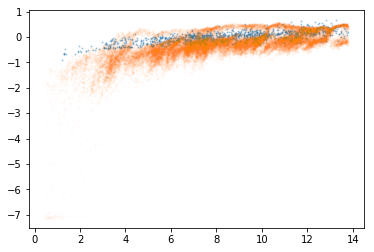

In [57]:
plt.scatter(timesChempy,FeHChempy,alpha=0.3,s=1)
plt.scatter(timesTNG,FeHTNG,alpha=0.03,s=1)

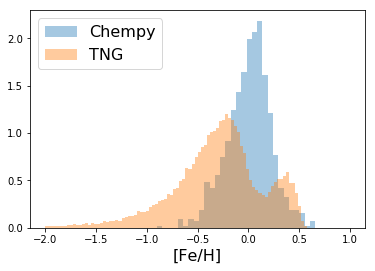

In [58]:
plt.hist(FeHChempy,alpha=0.4,density=True,bins=30,label='Chempy')
plt.hist(FeHTNG,alpha=0.4,density=True,bins=100,range=[-2,1],label='TNG');
plt.xlabel('[Fe/H]',fontsize=FS);plt.legend(fontsize=FS);

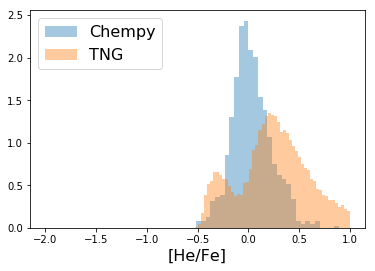

In [59]:
HeFeChempy=abuns[:,3]
plt.hist(HeFeChempy,alpha=0.4,density=True,bins=30,label='Chempy')
plt.hist(HeFeTNG,alpha=0.4,density=True,bins=100,range=[-2,1],label='TNG');
plt.xlabel('[He/Fe]',fontsize=FS);plt.legend(fontsize=FS);

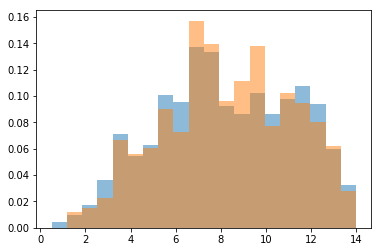

In [68]:
plt.hist(timesTNG,density=True,range=[0.5,14],bins=20,alpha=0.5);
plt.hist(timesChempy,density=True,range=[0.5,14],bins=20,alpha=0.5);

## Check HDF5 files

In [214]:
import h5py
file=h5py.File('Chempy/input/yields/TNG/SNII.hdf5')
list(file.keys())

file['Metallicities'].value

x=file['Yields']['Z_0.00']['Yield']

yields=file['Yields/Z_0.00/Yield'].value

['Masses',
 'Metallicities',
 'Number_of_masses',
 'Number_of_metallicities',
 'Number_of_species',
 'Reference',
 'Species_names',
 'Yield_names',
 'Yields']

In [256]:
file['Yields/Z_0.00']['Ejected_mass'].value

array([ 4.826783 ,  5.6431684,  8.089241 ,  8.657515 , 10.522303 ,
       13.076985 , 15.142041 , 18.797949 , 23.533358 , 32.104225 ,
       25.580933 , 58.175022 , 77.45127  ], dtype=float32)

In [ ]:
file.close()

## Create Plot of TNG yields to compare to TNG

In [137]:
# Load solar abundances
from Chempy.solar_abundance import solar_abundances
basic_solar = solar_abundances()
getattr(basic_solar, 'Asplund09')()

# Initialise the SSP class with time-steps

time_steps = np.linspace(0.,13.5,521)

# Load the default yields

from Chempy.yields import SN2_feedback, AGB_feedback, SN1a_feedback
basic_sn2 = SN2_feedback()
getattr(basic_sn2, 'TNG_net')()
basic_1a = SN1a_feedback()
getattr(basic_1a, "TNG")()
basic_agb = AGB_feedback()
getattr(basic_agb, "TNG_net")()

# Use all elements that are traced
elements_to_trace = els

# Producing the SSP birth elemental fractions (here we use solar)

solar_fractions = []
elements = np.hstack(basic_solar.all_elements)
for item in elements_to_trace:
    solar_fractions.append(float(basic_solar.fractions[np.where(elements==item)]))

list_of_metallicities = [0.02]#np.logspace(-4,-2,2)
list_of_SSP_tables = []
list_of_SSP_tables.append(list_of_metallicities)
list_of_SSP_tables.append(time_steps)

from Chempy.wrapper import SSP_wrap

In [156]:
basic_ssp = SSP_wrap(a)
basic_ssp.calculate_feedback(0.02,list(elements_to_trace),list(solar_fractions),np.copy(time_steps))

In [174]:
agbs,sn1as,sn2s=[],[],[]
for el in els:
    agbs.append(np.sum(basic_ssp.agb_table[el][:343]))
    sn1as.append(np.sum(basic_ssp.sn1a_table[el][:343]))
    sn2s.append(np.sum(basic_ssp.sn2_table[el][:343]))

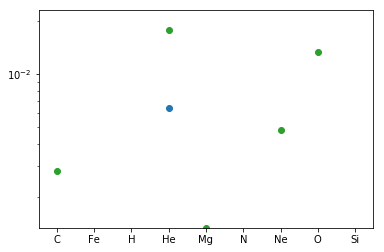

In [179]:
plt.scatter(els,agbs)
plt.scatter(els,sn1as)
plt.scatter(els,sn2s)
plt.yscale('log')

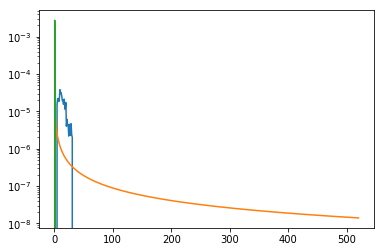

In [164]:
plt.plot(basic_ssp.agb_table['C'])
plt.plot(basic_ssp.sn1a_table['C'])
plt.plot(basic_ssp.sn2_table['C'])
plt.yscale('log')

In [138]:
def create_one_SSP_table(parameters):
    differential_table = True # True is the default Chempy behaviour
    metallicity = parameters
    basic_ssp = SSP_wrap(a)
    basic_ssp.calculate_feedback(metallicity,list(elements_to_trace),list(solar_fractions),np.copy(time_steps))

    x = basic_ssp.agb_table
    y = basic_ssp.sn1a_table
    z = basic_ssp.sn2_table
    s = basic_ssp.bh_table
    d = basic_ssp.table

    u = np.zeros_like(x)
    names = list(u.dtype.names)

    # here we still add all processes, but we can also make individual process contribution to element
    for j,jtem in enumerate(names):
        u[jtem] = x[jtem] + y[jtem] + z[jtem] + s[jtem]
    if differential_table:
        for el in elements_to_trace:
            d[el] = u[el]
    else:
        for el in elements_to_trace:
            d[el] = np.cumsum(u[el])
        for name in ['mass_of_ms_stars_dying', 'mass_in_remnants', 'sn2', 'sn1a', 'pn', 'bh', 'hydrogen_mass_accreted_onto_white_dwarfs', 'unprocessed_ejecta']:
            d[name] = np.cumsum(d[name])
    return(d)

In [139]:
print("There are %d CPUs on this machine" % mp.cpu_count())
number_processes = max(1,mp.cpu_count() - 1)
pool = mp.Pool(number_processes)
results = pool.map(create_one_SSP_table, list_of_metallicities)
pool.close()
pool.join()

list_of_SSP_tables.append(results)


There are 40 CPUs on this machine


In [149]:
x = list_of_SSP_tables[2][0]

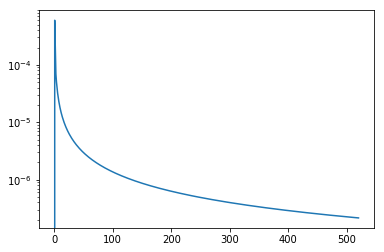

In [154]:
plt.plot(x['Fe'])
plt.yscale('log')

## Portinari Lifetimes

In [8]:
def Argast_life(m,Z):
    lm = np.log10(m)
    a0 =  3.79 + 0.24*Z
    a1 = -3.10 - 0.35*Z
    a2 =  0.74 + 0.11*Z
    tmp = a0 + a1*lm + a2*lm*lm
    return np.divide(np.power(10,tmp),1000)*1e9

In [9]:
port_file = np.genfromtxt('portinari_ages.csv',skip_header=1)
port_Z = np.genfromtxt('portinari_ages.csv',max_rows=1)
port_M = port_file[:,0]
port_life = port_file[:,1:]

In [10]:
PM,PZ=np.meshgrid(port_M,port_Z,indexing='xy')

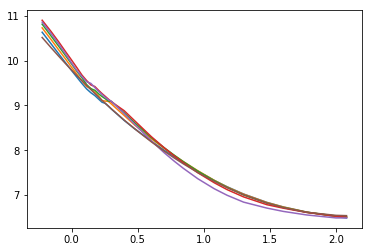

In [11]:
plt.plot(np.log10(port_M),np.log10(port_life));#plt.colorbar()
plt.plot(np.log10(port_M),np.log10(Argast_life(port_M,port_Z[0])))

In [12]:
PZ,PM=np.meshgrid(port_Z,port_M)

In [30]:
def linear_model(X,params):
    Z,M=X
    lZ=np.log10(Z)
    lM=np.log10(M)
    return (params[0]+lM*params[1]+np.power(lM,2.)*params[2]+lZ*params[3]+lM*lZ*params[4]+lM*lM*lZ*params[5]
            +lZ*lZ*params[6]+lZ*lZ*lM*params[7])+6

Fit with PyMC3

In [31]:
import pymc3 as pm

In [42]:
with pm.Model() as simple_model:
    params = pm.Normal('params',mu=np.asarray([3.6,-2.8,0.7,0.2,-0.3,0.1,0.1,0.1]),sd=np.ones(8),shape=(8,))
    Z=PZ.ravel()
    M=PM.ravel()
    lM=np.log10(M)
    lZ=np.log10(Z)
    data=np.log10(port_life).ravel()
    like = pm.Normal('obs',mu=params[0]+lM*params[1]+np.power(lM,2.)*params[2]+lZ*params[3]+lM*lZ*params[4]
                     +lM*lM*lZ*params[5]+lZ*lZ*params[6]+lZ*lZ*lM*params[7]+6,
                    sd=0.01*data,observed=data)

In [43]:
with simple_model:
    trace=pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [params]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:38<00:00, 157.86draws/s]
/home/oliverphilcox/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)
The acceptance probability does not match the target. It is 0.8941184425538392, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8798723109147175, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


In [44]:
pm.summary(trace)

/home/oliverphilcox/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
params__0,4.015361,0.113694,0.003336,3.793616,4.234396,992.836885,1.000330
params__1,-3.910899,0.139816,0.004078,-4.180871,-3.639006,1008.687188,1.001419
params__2,0.999472,0.051646,0.001215,0.897202,1.099633,1306.001721,1.001694
params__3,-0.036018,0.100941,0.002941,-0.229804,0.167613,992.216133,1.000326
params__4,-0.311397,0.101580,0.003038,-0.507175,-0.106757,986.002544,1.000584
params__5,0.091091,0.022622,0.000525,0.045118,0.133978,1298.544198,1.002009
params__6,-0.032184,0.021013,0.000597,-0.071897,0.010939,1018.347407,1.000323
params__7,-0.013231,0.019627,0.000562,-0.050529,0.027229,1076.303295,0.999644


In [45]:
par=trace.get_values('params').mean(axis=0)

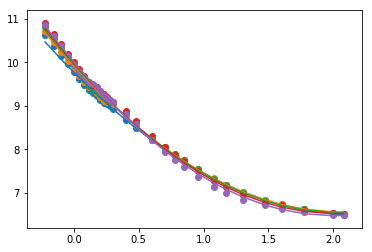

In [46]:
for i in range(len(port_Z)):
    plt.plot(np.log10(port_M),linear_model([port_Z[i],port_M],par))
    plt.scatter(np.log10(port_M),np.log10(port_life[:,i]));#plt.colorbar()


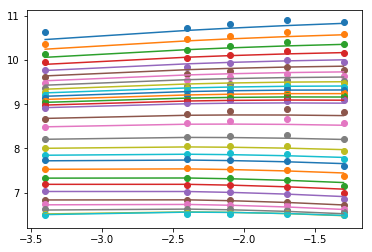

In [47]:
for i in range(len(port_M)):
    plt.plot(np.log10(port_Z),linear_model([port_Z,port_M[i]],par))
    plt.scatter(np.log10(port_Z),np.log10(port_life[i,:]));

In [48]:
def linear_model(inputs,a00,a10,a20,all_par=[],use_par=False):
    logM,Z=inputs
    if use_par:
        a00,a10,a20=all_par
    tmp=a00+a10*logM+a20*logM*logM
    return np.divide(np.power(10,tmp),1000)*1e9

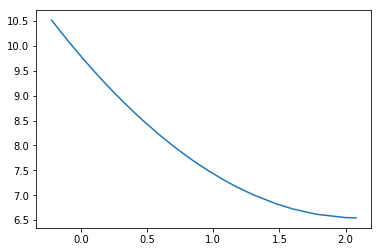

In [49]:
plt.plot(np.log10(port_M),np.log10(linear_model([np.log10(port_M),port_Z[0]],3.79,-3.1,0.74)))

In [283]:
from scipy.optimize import curve_fit

In [284]:
out_par

array([-5.00311914, -0.15650512,  0.0319775 ])

In [285]:
out_par,cov=curve_fit(linear_model,[np.log10(PM.ravel()),PZ.ravel()],np.log10(port_life.ravel()),p0=[3.79,-3.1,0.74])

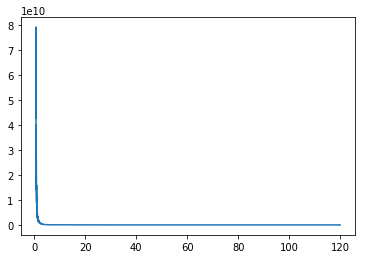

In [294]:
plt.plot(PM.T.ravel(),port_life.ravel())

In [290]:
PM

array([[  0.6,   0.7,   0.8,   0.9,   1. ,   1.1,   1.2,   1.3,   1.4,
          1.5,   1.6,   1.7,   1.8,   1.9,   2. ,   2.5,   3. ,   4. ,
          5. ,   6. ,   7. ,   9. ,  12. ,  15. ,  20. ,  30. ,  40. ,
         60. , 100. , 120. ],
       [  0.6,   0.7,   0.8,   0.9,   1. ,   1.1,   1.2,   1.3,   1.4,
          1.5,   1.6,   1.7,   1.8,   1.9,   2. ,   2.5,   3. ,   4. ,
          5. ,   6. ,   7. ,   9. ,  12. ,  15. ,  20. ,  30. ,  40. ,
         60. , 100. , 120. ],
       [  0.6,   0.7,   0.8,   0.9,   1. ,   1.1,   1.2,   1.3,   1.4,
          1.5,   1.6,   1.7,   1.8,   1.9,   2. ,   2.5,   3. ,   4. ,
          5. ,   6. ,   7. ,   9. ,  12. ,  15. ,  20. ,  30. ,  40. ,
         60. , 100. , 120. ],
       [  0.6,   0.7,   0.8,   0.9,   1. ,   1.1,   1.2,   1.3,   1.4,
          1.5,   1.6,   1.7,   1.8,   1.9,   2. ,   2.5,   3. ,   4. ,
          5. ,   6. ,   7. ,   9. ,  12. ,  15. ,  20. ,  30. ,  40. ,
         60. , 100. , 120. ],
       [  0.6,   0.7,   0.8,

In [287]:
out_par

array([-5.05539581, -0.03272122,  0.00822409])

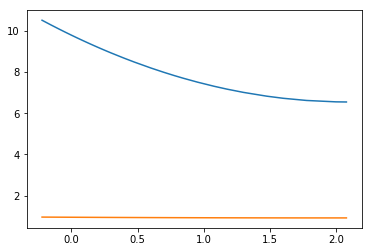

In [288]:
plt.plot(np.log10(port_M),np.log10(linear_model([np.log10(port_M),port_Z[0]],3.79,-3.1,0.74)))
plt.plot(np.log10(port_M),np.log10(linear_model([np.log10(port_M),port_Z[0]],0,0,0,all_par=out_par,use_par=True)))

In [91]:
from scipy.optimize import curve_fit

In [107]:
log_times = np.log10(port_life.ravel()/1e9*1000)

In [170]:
def like_fn2(par,a00,a01,a10):#,a11,a20):
    lm,Z=par
    return a00+a01*Z+a10*lm#+a11*lm*Z+a20*lm*lm

In [171]:
logM = np.log10(PM.ravel())
Z = PZ.ravel()
fit_par,cov_mat=curve_fit(like_fn2,[logM,Z],log_times,p0=[3.79,0.24,-3.1])#,-0.35,0.74])

In [172]:
err = np.sqrt(np.linalg.eigvalsh(cov_mat))
for i in range(len(fit_par)):
    print("%.2f +- %.2f"%(fit_par[i],err[i]))

3.83 +- 0.03
-64.93 +- 0.08
-0.36 +- 2.28


In [173]:
port_Z[0]

0.0004

In [176]:
def port_fit(m,Z,par=fit_par):
    lm = np.log10(m)
    a00,a01,a10=par#,a11,a20=par
    a0 =  a00 + a01*Z
    a1 =  a10 #+ a11*Z
    #a2 =  a20
    tmp = a0 + a1*lm #+ a2*lm*lm
    return np.divide(np.power(10,tmp),1000)*1e9

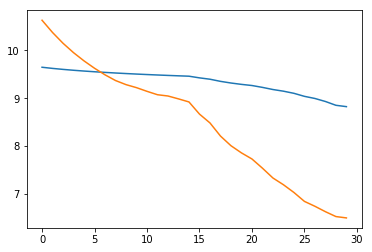

In [178]:
plt.plot(np.log10(port_fit(port_M,0.004)))
plt.plot(np.log10(port_life[:,0]))

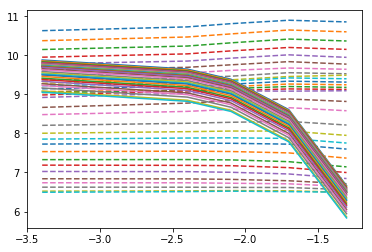

In [179]:
port_model = []


plt.plot(np.log10(port_Z),np.log10(port_life.T),ls='--')
for i,mi in enumerate(port_M):
    plt.plot(np.log10(port_Z),np.log10(port_fit(mi,port_Z,fit_par)))
    #plt.plot(np.log10(port_Z),10.**(np.log10(Argast_life(mi,port_Z))-np.log10(port_life.T)[:,i]))

In [72]:
def Argast_life(m,Z):
    lm = np.log10(m)
    a0 =  3.79 + 0.24*Z
    a1 = -3.10 - 0.35*Z
    a2 =  0.74 + 0.11*Z
    tmp = a0 + a1*lm + a2*lm*lm
    return np.divide(np.power(10,tmp),1000)*1e9

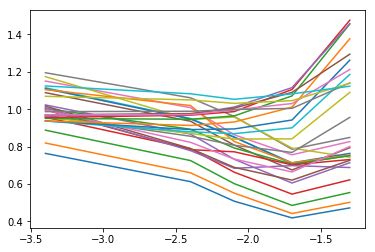

In [77]:
#plt.plot(np.log10(port_Z),np.log10(port_life.T),ls='--')
for i,mi in enumerate(port_M):
    plt.plot(np.log10(port_Z),10.**(np.log10(Argast_life(mi,port_Z))-np.log10(port_life.T)[:,i]))